In [1]:
# %%
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import pennylane as qml
from functools import partial, reduce
import matplotlib.pyplot as plt
from utils.helper import *
from utils.models import *

jax.config.update("jax_enable_x64", True)
key = jr.PRNGKey(0)

In [ ]:
n_qubits = 3

In [3]:
## Set your input state
key, inkey, outkey = jr.split(key, 3)
initial_state = jr.normal(inkey, shape=(2**n_qubits)).astype(complex)
target_state = jr.normal(outkey, shape=(2**n_qubits)).astype(complex)
## Normalize for safety
initial_state /= jnp.linalg.norm(initial_state)
target_state /= jnp.linalg.norm(target_state)

# 
n_epochs = 500
n_steps = 40
T = 1.0
lr = 0.05

## Chooce Your Hamiltonian Ansatz
H_list = build_hamiltonians(n_qubits)

In [4]:
## 
key, mlpkey = jax.random.split(key)

model = eqx.nn.MLP(
   in_size='scalar', out_size=len(H_list)-1, depth=2, width_size=16, activation=jax.nn.tanh, key=mlpkey
)
## GRAPE Algorithm
#model = PiecewiseConstantControl(
#    amplitudes=jnp.zeros((n_steps, len(H_list))), 
#    t_final= T, 
#    n_segments=n_steps
#)
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

In [5]:
# Build circuit for training
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def splitting_circuit(model, initial_state, T, 
                      n_steps, 
                      H_list = H_list,
                      n_qubits=n_qubits, 
                      n=1
    ):
    """ 
    model: control NN
    initial_state: Initial Quantum State
    T: final time
    n_steps: time steps
    H_list : Hamiltanians
    n: trotterizaiton order
    """
    dt = T / n_steps
    H0 = H_list[0]
    qml.StatePrep(initial_state, wires=range(n_qubits))
    for k in range(n_steps):
        t_k = k * dt
        u_k = model(jnp.array(t_k))
        # Strang-splitting time step
        qml.ApproxTimeEvolution(H0, dt/2, n)
        for u, H in zip(list(u_k), H_list[1:]): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        for u, H in (zip(reversed(list(u_k)), reversed(H_list[1:]))): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        qml.ApproxTimeEvolution(H0, dt/2, n)
    return qml.state()

In [6]:
def loss_fn(model, inital_state, target_state, T=1.0, n_steps=40, C=1e-5):
    psi = splitting_circuit(model, inital_state, T, n_steps)
    fidelity = quantum_fidelity(psi, target_state)
    ## 
    ts = jnp.linspace(0, T, n_steps)
    integral = jax.scipy.integrate.trapezoid(jax.vmap(lambda t : jnp.linalg.norm(model(t))**2)(ts), ts)
    #return jnp.linalg.norm(psi-target_state)**2 + C*integral
    return 1 - fidelity + C*integral

@eqx.filter_jit
def make_step(model, opt_state, initial_state, target_state, optimizer, T=1.0, n_steps=40):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, initial_state, target_state, T, n_steps)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

# Training
print(f"=== Start training ===")
for step in range(n_epochs):
    model, opt_state, loss = make_step(
        model, opt_state, initial_state, 
        target_state, optimizer, T, n_steps
    )
    if step % (n_epochs // 10) == 0:
        print(f"Step {step:03d}: loss = {loss:.6f}")

rho_f = splitting_circuit(model, initial_state, T, n_steps)
print(f"Final fidelity: {quantum_fidelity(rho_f, target_state)}")


=== Start training ===
Step 000: loss = 0.960356
Step 050: loss = 0.308491
Step 100: loss = 0.251894
Step 150: loss = 0.222938
Step 200: loss = 0.193537
Step 250: loss = 0.170902
Step 300: loss = 0.146628
Step 350: loss = 0.129363
Step 400: loss = 0.123259
Step 450: loss = 0.118546
Final fidelity: 0.8868928992478374


In [7]:
jnp.linalg.norm(splitting_circuit(model, initial_state, 0, n_steps)- initial_state)

Array(1.42292593e-13, dtype=float64)

Final fidelity: 0.886893


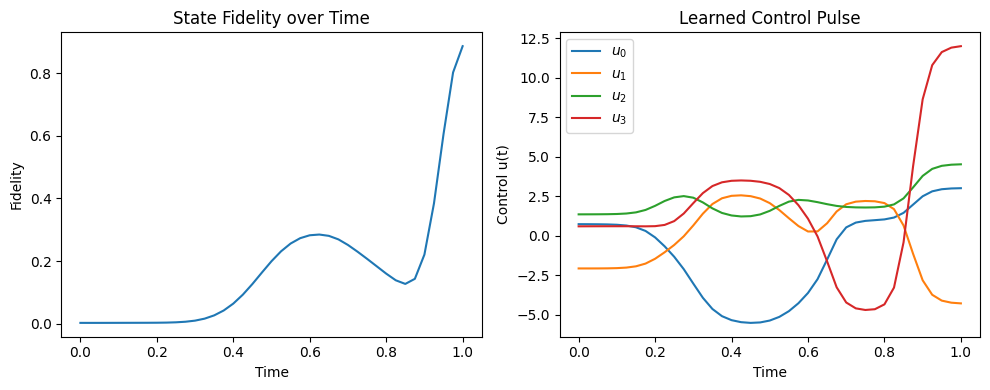

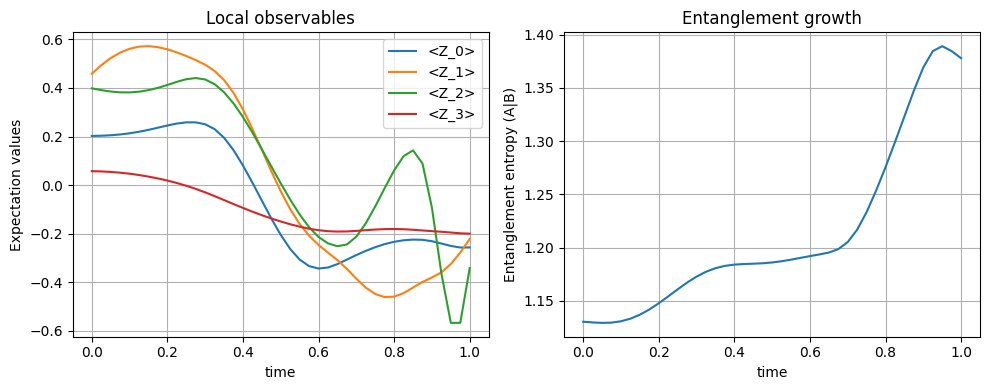

In [12]:
# %%
def simulate_trajectory(model, initial_state, T, 
                      n_steps, 
                      H_list = H_list,
                      n_qubits=n_qubits, 
                      n=1
    ):
    dt = T / n_steps
    dev = qml.device("default.qubit", wires=n_qubits)

    H0 = H_list[0]

    @qml.qnode(dev)
    def step_evolution(psi_in, u_k):
        qml.StatePrep(psi_in, wires=range(n_qubits))
        qml.ApproxTimeEvolution(H0, dt/2, n)
        for u, H in zip(list(u_k), H_list[1:]): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        for u, H in (zip(reversed(list(u_k)), reversed(H_list[1:]))): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        qml.ApproxTimeEvolution(H0, dt/2, n)
        return qml.state()

    psi = initial_state
    states = [psi]

    for k in range(n_steps):
        t_k = k * dt
        u_k = model(jnp.array(t_k))
        psi = step_evolution(psi, u_k)
        # normalize for safety
        # psi = psi / jnp.linalg.norm(psi)
        states.append(psi)
    
    return jnp.stack(states)

# %%
trajectory_fidelity = jax.vmap(quantum_fidelity, in_axes=(0, None))
states = simulate_trajectory(model, initial_state, T=T, n_steps=n_steps)

fidelities = trajectory_fidelity(states, target_state)
print(f"Final fidelity: {fidelities[-1]:.6f}")

# %%

times = jnp.linspace(0, T, len(fidelities))
controls = jax.vmap(model)(times)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(times, fidelities)
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("State Fidelity over Time")

plt.subplot(1,2,2)
for i in range(controls.shape[-1]):
    plt.plot(times, controls[:, i], label=f"$u_{i}$")
plt.xlabel("Time")
plt.ylabel("Control u(t)")
plt.title("Learned Control Pulse")
plt.legend()

plt.tight_layout()
plt.show()

#visualize_bloch_trajectories(states, target_state, n_qubits)

# Expectation value
def expectation_value(psi, operator):
    return jnp.real(jnp.vdot(psi, operator @ psi))

# Pauli matrices
I = jnp.array([[1,0],[0,1]], dtype=complex)
X = jnp.array([[0,1],[1,0]], dtype=complex)
Y = jnp.array([[0,-1j],[1j,0]], dtype=complex)
Z = jnp.array([[1,0],[0,-1]], dtype=complex)

def kron_all(ops):
    return reduce(jnp.kron, ops)

def pauli_on_qubit(pauli, i, n):
    ops = [I]*n
    ops[i] = pauli
    return kron_all(ops)

# Entanglement entropy for subsystem A
def entanglement_entropy(psi, n_qubits, A):
    """
    psi: statevector
    A: list of qubit indices belonging to subsystem A
    """
    psi_tensor = psi.reshape([2]*n_qubits)
    B = [i for i in range(n_qubits) if i not in A]
    perm = A + B
    psi_perm = jnp.transpose(psi_tensor, perm)

    dA = 2**len(A)
    dB = 2**len(B)
    psi_matrix = psi_perm.reshape(dA, dB)

    rhoA = psi_matrix @ psi_matrix.conj().T
    eigvals = jnp.linalg.eigvalsh(rhoA)
    eigvals = eigvals[eigvals > 1e-12]

    return -jnp.sum(eigvals * jnp.log2(eigvals))





# Observables: here σz on each qubit
observables = [pauli_on_qubit(Z, i, n_qubits) for i in range(n_qubits)]

fidelities = []
expect_vals = {i: [] for i in range(n_qubits)}     # <Z_i>
entropies = []

A = list(range(n_qubits // 2))  # bipartition for entanglement entropy

for psi in states:
    fidelities.append(quantum_fidelity(psi, target_state))

    for i, op in enumerate(observables):
        expect_vals[i].append(expectation_value(psi, op))

    entropies.append(entanglement_entropy(psi, n_qubits, A))


# ------------------------------------------------------------
# Plotting
# ------------------------------------------------------------



# Expectation values plot
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
for i in expect_vals:
    plt.plot(times, expect_vals[i], label=f"<Z_{i}>")
plt.xlabel("time")
plt.ylabel("Expectation values")
plt.legend()
plt.title("Local observables")
plt.grid(True)

# Entanglement entropy plot
plt.subplot(1,2,2)
plt.plot(times, entropies)
plt.xlabel("time")
plt.ylabel("Entanglement entropy (A|B)")
plt.title("Entanglement growth")
plt.grid(True)
plt.tight_layout()
plt.show()



## Circuit Visualization

We use `pennylane.transforms.decompose` to transpile the circuit

In [9]:
from pennylane.transforms import decompose

dev = qml.device('default.qubit')
allowed_gates = {qml.RX, qml.RY, qml.RZ, qml.CNOT}

@partial(decompose, gate_set=allowed_gates)
#@qml.compile
@qml.qnode(dev)
def circuit(H_list= H_list, n=1):
    H0 = H_list[0]
    dt = T/n_steps
    qml.StatePrep(initial_state, wires=range(n_qubits))  # |00>
    for k in range(n_steps):
        t_k = k * dt
        u_k = model(jnp.array(t_k))
        # Strang-splitting time step
        qml.ApproxTimeEvolution(H0, dt/2, n)
        for u, H in zip(list(u_k), H_list[1:]): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        for u, H in (zip(reversed(list(u_k)), reversed(H_list[1:]))): 
            qml.ApproxTimeEvolution(u*H, dt/2, n)
        qml.ApproxTimeEvolution(H0, dt/2, n)
    
    return qml.state()
print(qml.draw(circuit)())



0: ──RY(1.37)─╭●───────────╭●───────────────╭●─────────────────────────╭●──────────────── ···
1: ──RY(1.01)─╰X──RY(0.29)─╰X─╭●────────────│─────────────╭●───────────│───────────────╭● ···
2: ──RY(1.21)─────────────────╰X──RY(-0.46)─╰X──RY(-0.43)─╰X──RY(0.31)─╰X─╭●───────────│─ ···
3: ──RY(1.32)─────────────────────────────────────────────────────────────╰X──RY(0.30)─╰X ···

0: ··· ─────────────────────────╭●───────────────────────────────────────────────────╭● ···
1: ··· ─────────────────────────│──────────────────────────╭●────────────────────────│─ ···
2: ··· ───────────╭●────────────│─────────────╭●───────────│────────────╭●───────────│─ ···
3: ··· ──RY(0.03)─╰X──RY(-0.19)─╰X──RY(-0.30)─╰X──RY(0.12)─╰X──RY(0.03)─╰X──RY(0.28)─╰X ···

0: ··· ──RZ(1.18)──╭●────────────╭●───────────────╭●──────────────────────────╭●────────────── ···
1: ··· ──RZ(-0.39)─╰X──RZ(-0.39)─╰X─╭●────────────│─────────────╭●────────────│─────────────── ···
2: ··· ──RZ(-0.39)──────────────────╰X──RZ(-0.39)─╰X──RZ